In [1]:
include("../src/Conduction.jl");
using Plots, LaTeXStrings;

In [2]:
semiconductor = Conduction.Semiconductor(
1.38 * 10^-23, # Boltzman constant (J.K^-1)
1.6*10^-19, # Electron's charge (C)
10^7, # decay constant of the assumed hydrogen-like localized state wave functions (cm^-1)
0.1 * 1.6*10^-19, # Mode effect of the phonons (J)
2.1 * 10^18, # intrinsic semiconductor's density (cm^-3)
0, # Doping states' density (cm^-3)
0.1 * 1.6 * 10^-19, # Energy to a vacant target site (J)
-2*10^3, # Field (V.cm^-1)
10^13, # Base electron jump rate
-10.0, # Fermi level (J)
2.7, # Intrinsic semiconductor's gaussian width (J)
2.7, # Doping states' gaussian width (J)
2.7 # Amount of disorder
);

T = 300;
range = -15:1:15;

In [3]:
Rnn_VRH = (x -> Conduction.RnnVRH(semiconductor, x, T)).(range);
Rnn_Perco = (x -> Conduction.RnnPercoField(semiconductor, x, T)).(range);

In [4]:
xf_VRH = ((x, y) -> Conduction.xf(semiconductor, x, y, T)).(Rnn_VRH, range);
xf_Perco = ((x, y) -> Conduction.xf(semiconductor, x, y, T)).(Rnn_Perco, range);

In [5]:
mu_VRH = ((x, y) -> Conduction.electronMobility(semiconductor, x, y)).(Rnn_VRH, xf_VRH);
mu_Perco = ((x, y) -> Conduction.electronMobility(semiconductor, x, y)).(Rnn_Perco, xf_Perco);

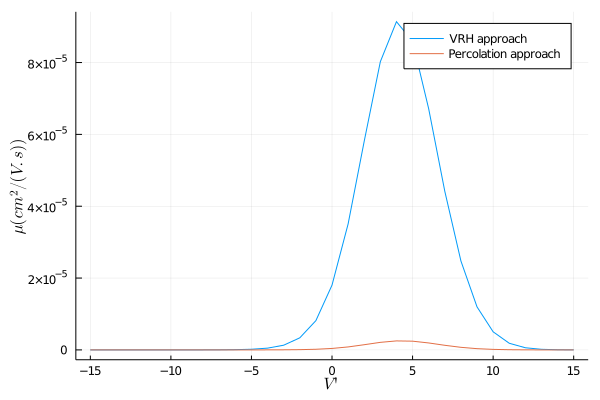

In [6]:
plot(range, mu_VRH, xlabel=L"V'", ylabel=L"\mu (cm^2/(V.s))", label="VRH approach")
plot!(range, mu_Perco, label="Percolation approach")

In [18]:
sigma_VRH =  semiconductor.k * T * semiconductor.q * (x -> Conduction.DOS(semiconductor, x, T)).(range).*(x -> Conduction.F(semiconductor, x, T)).(range) .* mu_VRH;
sigma_Perco =  semiconductor.k * T * semiconductor.q * (x -> Conduction.DOS(semiconductor, x, T)).(range).*(x -> Conduction.F(semiconductor, x, T)).(range) .* mu_Perco;

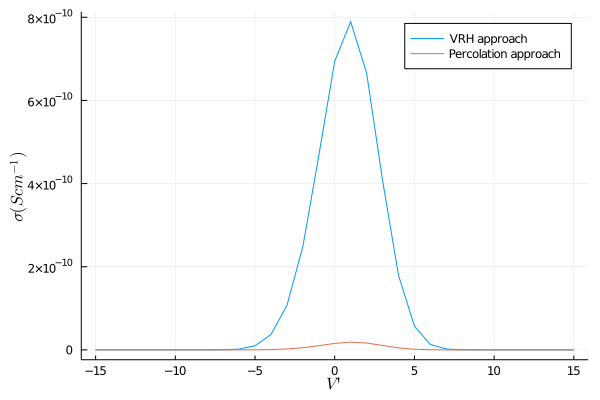

In [23]:
plot(range, sigma_VRH, xlabel=L"V'", ylabel=L"\sigma (S cm^{-1})", label="VRH approach")
plot!(range, sigma_Perco, label="Percolation approach")

In [29]:
g(x, y) = Conduction.electronMobility(semiconductor, x, y);
f(x) = semiconductor.k * T * semiconductor.q * (x -> Conduction.DOS(semiconductor, x, T))(x) * (x -> Conduction.F(semiconductor, x, T))(x);
function h(x, Rnn)
    xf = Conduction.xf(semiconductor, Rnn, x, T);
    f(x) * g(Rnn, xf)
end;

h_VRH(x) = h(x, Conduction.RnnVRH(semiconductor, x, T));
h_Perco(x) = h(x, Conduction.RnnPercoField(semiconductor, x, T));

conductivity_VRH = Conduction.average_density_integral(h_VRH, 15);
conductivity_Perco = Conduction.average_density_integral(h_Perco, 15);

In [30]:
println(conductivity_VRH)
println(conductivity_Perco)

3.6818250983001922e-9
8.71316881796603e-11
